## Split CIFAR-10 into training, validation, and testing sets

In [1]:
##########################
### SETTINGS
##########################

NUM_CLASSES = 10

# Hyperparameters
random_seed = 1
lr = 0.001
num_epochs = 60
batch_size = 16

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1428: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


## Visualize image for each class

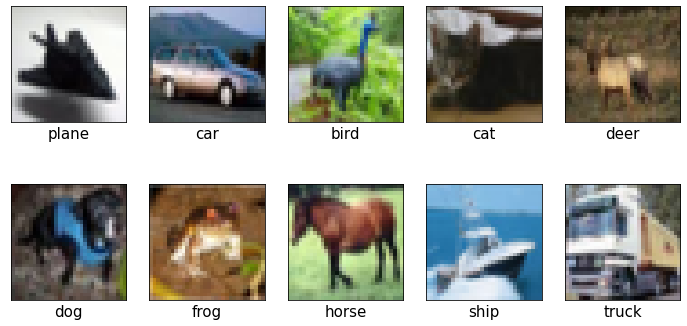

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Define CNN architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

net = models.vgg16(pretrained=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Device: cuda:0
Number of trainable parameters: 138357544


## Training

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(int (num_epochs/2)):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

[epoch 1] loss: 0.18189 accuracy: 0.0968 val loss: 0.14488 val accuracy: 0.1006
[epoch 2] loss: 0.14340 accuracy: 0.1267 val loss: 0.12996 val accuracy: 0.1922
[epoch 3] loss: 0.12719 accuracy: 0.2009 val loss: 0.12041 val accuracy: 0.2512
[epoch 4] loss: 0.11971 accuracy: 0.2485 val loss: 0.11305 val accuracy: 0.3091
[epoch 5] loss: 0.11324 accuracy: 0.3040 val loss: 0.10677 val accuracy: 0.3508
[epoch 6] loss: 0.10805 accuracy: 0.3404 val loss: 0.10450 val accuracy: 0.3697
[epoch 7] loss: 0.10159 accuracy: 0.3866 val loss: 0.09845 val accuracy: 0.4112
[epoch 8] loss: 0.09623 accuracy: 0.4198 val loss: 0.09207 val accuracy: 0.4453
[epoch 9] loss: 0.09243 accuracy: 0.4458 val loss: 0.08944 val accuracy: 0.4745
[epoch 10] loss: 0.08780 accuracy: 0.4790 val loss: 0.08711 val accuracy: 0.4865
[epoch 11] loss: 0.08402 accuracy: 0.5044 val loss: 0.07966 val accuracy: 0.5325
[epoch 12] loss: 0.08009 accuracy: 0.5305 val loss: 0.07928 val accuracy: 0.5327
[epoch 13] loss: 0.07683 accuracy: 0.

In [6]:
from google.colab import files, drive
name = 'vgg16_weigh_epoch' + str(int(num_epochs/2)) + '.pth'
torch.save(net.state_dict(), name)
# download checkpoint file
# files.download('vgg16_weight.pth')
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
net.load_state_dict(torch.load(name))

<All keys matched successfully>

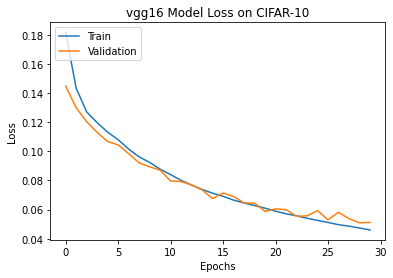

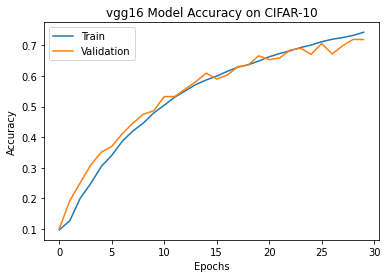

In [8]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('vgg16 Model Loss on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('vgg16 Model Accuracy on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## **Training on 31-60**

In [9]:
for epoch in range(int (num_epochs/2), num_epochs):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

[epoch 31] loss: 0.04464 accuracy: 0.7488 val loss: 0.04592 val accuracy: 0.7475
[epoch 32] loss: 0.04390 accuracy: 0.7536 val loss: 0.04534 val accuracy: 0.7530
[epoch 33] loss: 0.04279 accuracy: 0.7585 val loss: 0.05103 val accuracy: 0.7203
[epoch 34] loss: 0.04194 accuracy: 0.7630 val loss: 0.04599 val accuracy: 0.7467
[epoch 35] loss: 0.04099 accuracy: 0.7698 val loss: 0.04477 val accuracy: 0.7489
[epoch 36] loss: 0.04010 accuracy: 0.7766 val loss: 0.04555 val accuracy: 0.7513
[epoch 37] loss: 0.03907 accuracy: 0.7816 val loss: 0.04375 val accuracy: 0.7595
[epoch 38] loss: 0.03854 accuracy: 0.7837 val loss: 0.04405 val accuracy: 0.7596
[epoch 39] loss: 0.03778 accuracy: 0.7904 val loss: 0.04396 val accuracy: 0.7609
[epoch 40] loss: 0.03680 accuracy: 0.7963 val loss: 0.04363 val accuracy: 0.7640
[epoch 41] loss: 0.03595 accuracy: 0.7978 val loss: 0.04301 val accuracy: 0.7664
[epoch 42] loss: 0.03536 accuracy: 0.8014 val loss: 0.04389 val accuracy: 0.7643
[epoch 43] loss: 0.03472 acc

In [10]:
from google.colab import files, drive
name = 'vgg16_weigh_epoch' + str(num_epochs) + '.pth'
torch.save(net.state_dict(), name)
# download checkpoint file
# files.download('vgg16_weight.pth')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
net.load_state_dict(torch.load(name))

<All keys matched successfully>

## Plotting training statistics

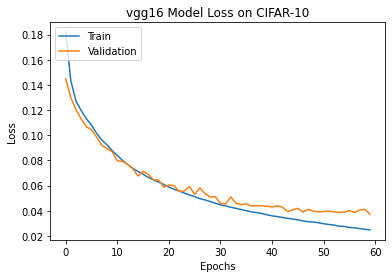

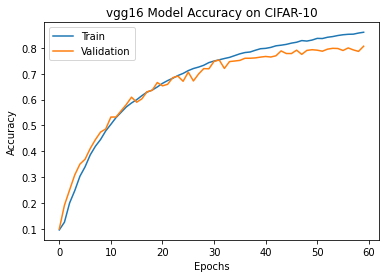

In [12]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('vgg16 Model Loss on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('vgg16 Model Accuracy on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## Save the trained model

In [13]:
from google.colab import files, drive
name = 'vgg16_weigh_epoch' + str(num_epochs) + '.pth'
torch.save(net.state_dict(), name)
# download checkpoint file
# files.download('vgg16_weight.pth')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
net.load_state_dict(torch.load(name))

<All keys matched successfully>

## Testing

In [15]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 79.82 %


## Visualize wrongly classified image for each class

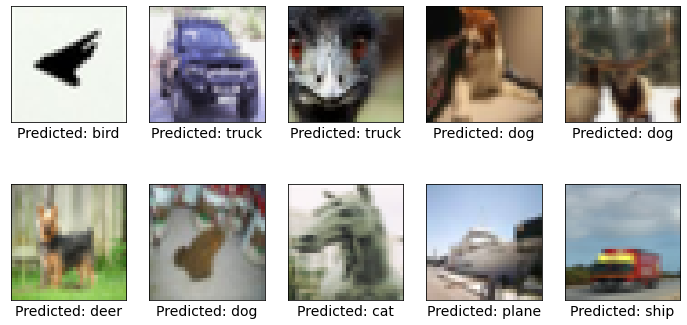

In [16]:
import numpy as np

# visualize wrongly classified image for each class
pred_vec = pred_vec.cpu().numpy()
ground_truths = np.asarray(test_set.targets)
incorrect_mask = pred_vec != ground_truths
incorrect_images = [test_set.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results = [pred_vec[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results[i]], fontsize=14)
    axis.imshow(incorrect_images[i])
    i += 1